In [1]:
### Imports
# Modules
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utilities
from imgaug import augmenters as iaa
from random import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Keras
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout, MaxPooling2D
from keras.regularizers import l2

# Plot in the notebook
%matplotlib inline

Using TensorFlow backend.


In [16]:
# Constants
DATA_DIR = 'data/'
CSV_FILE = 'driving_log.csv'

# Generator parameters
BATCH_SIZE = 32

# Cropping parameters
TOP_STRIDE_TO_CROP = 30
BOTTOM_STRIDE_TO_CROP = 25

# Image processing parameters
angle_treshold = 0.1
zero_discard_prob = 0.75

steering_correction = 0.25

NEW_WIDTH, NEW_HEIGHT = 64, 64

### Load data

In [3]:
# Load csv log file
csv_file = []
with open(DATA_DIR+CSV_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_file.append(line)

In [4]:
# Split csv in train and validation sets
csv_train, csv_valid = train_test_split(csv_file, test_size = 0.2)

In [5]:
# Load images and steering data
images = []
measurements = []
for line in csv_file:
    source_path = 'data/' + line[0]
    image = cv2.imread(source_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)
X_train = np.array(images)
y_train = np.array(measurements)

### Transformation functions

In [6]:
# Image transformations
# Transformation list:
tr_list = [iaa.Add((-75, 75)), # change brightness of images (by -10 to 10 of original value)
           iaa.Multiply((0.5, 2.0)),
           iaa.ContrastNormalization((0.5, 2.0)), # improve or worsen the contrast
           iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
           iaa.AdditiveGaussianNoise(scale=(0, 0.1*255))]
seq = iaa.SomeOf((0, 2), tr_list)

In [7]:
def crop_resize(image):
    height = image.shape[0]
    cropped_image = image[TOP_STRIDE_TO_CROP:height-BOTTOM_STRIDE_TO_CROP, :, :]
    return cv2.resize(cropped_image,(new_height, new_width), interpolation=cv2.INTER_AREA)

In [8]:
# Get sample image for testing
sample_idx = np.random.choice(len(csv_file))
path = DATA_DIR + csv_file[sample_idx][0].strip()
sample_image = cv2.imread(path)
sample_angle = csv_file[sample_idx][3]

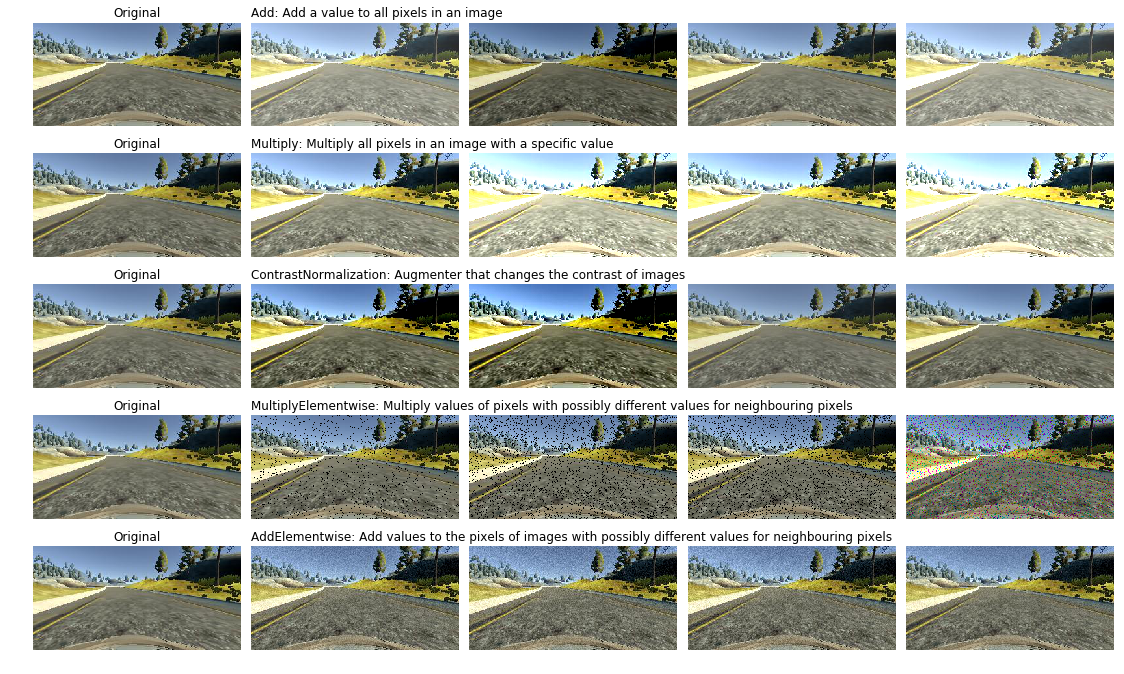

In [9]:
### Test image transformations
# Graph paramters
plot_width, plot_height = 15, 9
grid_rows, grid_cols = 5, 5
sample_size = grid_rows * grid_cols 

# Plot 
fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for tr_fn in tr_list:
    # Print non-transformed image
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    imgplt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Original')
    counter += 1
    # Print transformed images
    tr_images = tr_fn.augment_images([sample_image]*(grid_cols-1))
    print_title = True
    for tr_image in tr_images:
        imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
        imgplt.imshow(cv2.cvtColor(tr_image, cv2.COLOR_BGR2RGB))
        imgplt.axis('off')
        if print_title:
            imgplt.set_title('{}: {}'.format(tr_fn.name[7:],' '.join(tr_fn.__doc__.split('.')[0].split())), loc='left')
            print_title = False
        counter += 1

### Create generators

In [10]:
def transformed_data_generator(csv_file, batch_size = BATCH_SIZE, image_load = True, resize = True):
    
    # Camera parameters
    cameras = ['center', 'left', 'right']
    cameras_index = {'center':0, 'left':1, 'right':2} # 0:center, 1:left, 2:right
    cameras_steering_corretion = {'center':0, 'left':steering_correction, 'right':-steering_correction}
    
    num_samples = len(csv_file)
    
    cycles = 0
    
    while 1: # Loop forever so the generator never terminates
        
        shuffle(csv_file)
        counter = 0
        images = []
        angles = []
        for idx in range(0, num_samples):
            
            angle = float(csv_file[idx][3])
            ### Discard angles below treshold with certain prob
            if angle < angle_treshold and random() < zero_discard_prob:
                continue
            counter += 1

            ### Randomly choose center, left or right image
            # Get random camera 0:center, 1:left, 2:right 
            camera = np.random.choice(cameras)
            path = DATA_DIR + csv_file[idx][cameras_index[camera]].strip()
            if image_load:
                image = cv2.imread(path)
            else:
                image = np.zeros((160, 320, 3), dtype = np.uint8)
            # Adjust angle
            angle += cameras_steering_corretion[camera]            
            
            ### Random flip image with 0.5 prob
            if random() > 0.5:
                image = cv2.flip(image,1)
                angle *= -1.    
                        
            images.append(image)
            angles.append(angle)

            if counter == batch_size:
                images = np.array(images)
                ### Randomly apply image transformation
                if image_load:
                    images = seq.augment_images(images)

                ### Resize images
                if resize and image_load:
                    images = [crop_resize(image) for image in images]
                
                X_train = np.array(images)
                y_train = np.array(angles)
                
                counter = 0
                images = []
                angles = []
                
                yield shuffle(X_train, y_train)

In [11]:
def original_data_generator(csv_file, batch_size = BATCH_SIZE, image_load = True, resize = True):
    
    num_samples = len(csv_file)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(csv_file)
        counter = 0
        images = []
        angles = []
        
        for idx in range(0, num_samples):
            
            path = DATA_DIR + csv_file[idx][0].strip()
            if image_load:
                image = cv2.imread(path)
            else:
                image = np.zeros((160, 320, 3), dtype = np.uint8)
            angle = float(csv_file[idx][3])
            counter += 1
                        
            images.append(image)
            angles.append(angle)

            if counter == batch_size:
                images = np.array(images)
                ### Resize images
                if resize:
                    images = [crop_resize(image) for image in images]
                
                X_train = np.array(images)
                y_train = np.array(angles)
                
                counter = 0
                images = []
                angles = []
                
                yield shuffle(X_train, y_train)

In [12]:
train_data_generator = transformed_data_generator(csv_train)
valid_data_generator = original_data_generator(csv_valid)

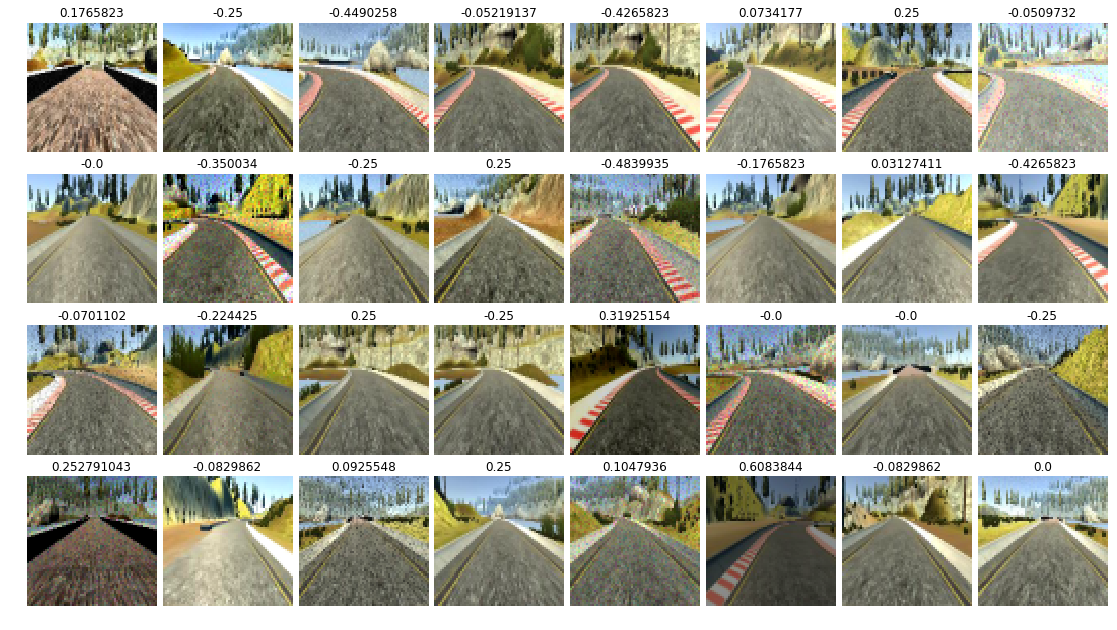

In [13]:
# Test transformed data generator
for images, angles in train_data_generator:
    break

plot_width, plot_height = 15, 8.3
grid_rows, grid_cols = 4, 8

fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for image, angle in zip(images, angles):
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    counter += 1
    imgplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title(angle)

Discard angles below 0.100000 with 75.000000% prob


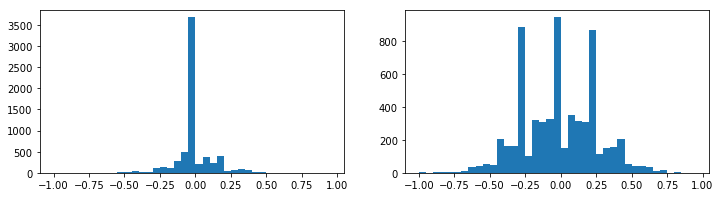

In [17]:
sample_size = 200

print('Discard angles below {:f} with {:%} prob'.format(angle_treshold, zero_discard_prob))

tr_angles = []
counter = 0
for images, angles in transformed_data_generator(csv_train, image_load = False):
    counter += 1
    tr_angles = np.concatenate((tr_angles, angles))
    if counter > sample_size: break

or_angles = []
counter = 0
for images, angles in original_data_generator(csv_train, image_load = False):
    counter += 1
    or_angles = np.concatenate((or_angles, angles))
    if counter > sample_size: break        
        
buckets = np.arange(-1,1,0.05)

fig = plt.figure(figsize = (12, 3))
#fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

hstplt = fig.add_subplot(1, 2, 1)
hist = hstplt.hist(or_angles, bins = buckets)

hstplt = fig.add_subplot(1, 2, 2)
hist = hstplt.hist(tr_angles, bins = buckets)

### Define models

In [18]:
def create_nv_model():
    # Define nvidia model
    model = Sequential()
    model.add(Cropping2D(cropping=((30,25),(0,0)), input_shape = (160, 320, 3)))
    model.add(Lambda(lambda x: x / 255.0 - 0.5))
    model.add(Conv2D(24, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(36, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(48, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(Conv2D(64, (3, 3), padding = 'valid', strides = (2, 2), activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(80))
    model.add(Dropout(0.5))
    model.add(Dense(40))
    model.add(Dropout(0.5))
    model.add(Dense(16))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

In [19]:
def create_lenet_model():
    # Define lenet model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (64, 64, 3)))
    model.add(Conv2D(1, (2, 2), padding = 'same', strides = (2,2), activation = 'relu', kernel_initializer = 'truncated_normal'))
    model.add(Conv2D(6, (5, 5), padding = 'valid', activation = 'relu', kernel_initializer = 'truncated_normal'))
    model.add(MaxPooling2D((2, 2), padding='valid'))
    model.add(Conv2D(16, (5, 5), padding = 'valid', activation = 'relu', kernel_initializer = 'truncated_normal'))
    model.add(MaxPooling2D((2, 2), padding='valid'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation = 'relu', kernel_initializer = 'truncated_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(84, activation = 'relu', kernel_initializer = 'truncated_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer = 'truncated_normal'))
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

In [20]:
def create_simple_model():
    # Define simple model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (64, 64, 3)))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

### Test models

### Lenet model with original data

In [ ]:
lenet_model = create_lenet_model()
lenet_history_object = lenet_model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, epochs = 20)
for images, angles in original_data_generator(csv_valid):
    break
steering_angles = lenet_model.predict(images)
print('{:s}\t{:s}\t{:s}'.format('Predicted', 'Angle', 'Abs. diff.'))
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

In [ ]:
### plot the training and validation loss for each epoch
plt.plot(lenet_history_object.history['loss'])
plt.plot(lenet_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [ ]:
# Save model
lenet_model.save('lenet_model.h5')

### Lenet model with generator

In [21]:
lenet_model = create_lenet_model()
lenet_history_object = lenet_model.fit_generator(transformed_data_generator(csv_train), steps_per_epoch = len(csv_train)/BATCH_SIZE,
                                 epochs=10, #FLAGS.epochs,
                                 validation_data = original_data_generator(csv_valid), validation_steps = len(csv_valid)/BATCH_SIZE)
for images, angles in original_data_generator(csv_valid):
    break
steering_angles = lenet_model.predict(images)
print('{:s}\t{:s}\t{:s}'.format('Predicted', 'Angle', 'Abs. diff.'))
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

Epoch 1/10
201/200 [==============================] - 25s - loss: 0.0622 - val_loss: 0.0200
Epoch 2/10
201/200 [==============================] - 23s - loss: 0.0425 - val_loss: 0.0178
Epoch 3/10
201/200 [==============================] - 24s - loss: 0.0374 - val_loss: 0.0195
Epoch 4/10
201/200 [==============================] - 24s - loss: 0.0347 - val_loss: 0.0225
Epoch 5/10
201/200 [==============================] - 24s - loss: 0.0329 - val_loss: 0.0193
Epoch 6/10
201/200 [==============================] - 24s - loss: 0.0319 - val_loss: 0.0172
Epoch 7/10
201/200 [==============================] - 24s - loss: 0.0316 - val_loss: 0.0215
Epoch 8/10
201/200 [==============================] - 24s - loss: 0.0311 - val_loss: 0.0163
Epoch 9/10
201/200 [==============================] - 24s - loss: 0.0295 - val_loss: 0.0168
Epoch 10/10
201/200 [==============================] - 24s - loss: 0.0300 - val_loss: 0.0173
Predicted	Angle	Abs. diff.
-0.106313	0.167014	0.273327
-0.063861	0.167014	0.230

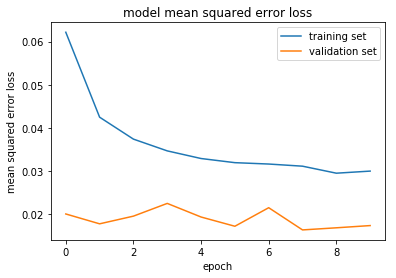

In [22]:
### plot the training and validation loss for each epoch
plt.plot(lenet_history_object.history['loss'])
plt.plot(lenet_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [24]:
# Save model
lenet_model.save('models/lenet_model.h5')

In [33]:
print(lenet_model.input_shape == (None, 64, 64, 3))
# for attr in dir(lenet_model):
#     print('-->', attr, getattr(lenet_model, attr))

True


In [ ]:
simple_model = create_simple_model()
simple_history_object = simple_model.fit_generator(original_data_generator(csv_train), steps_per_epoch = len(csv_train)/BATCH_SIZE,
                                 epochs=5, #FLAGS.epochs,
                                 validation_data = original_data_generator(csv_valid), validation_steps = len(csv_valid)/BATCH_SIZE)
for images, angles in valid_data_generator:
    break
steering_angles = simple_model.predict(images)
print(steering_angles.T)

In [ ]:
simple_model = create_simple_model()
simple_model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, epochs = 5)
for images, angles in valid_data_generator:
    break
steering_angles = simple_model.predict(images)
print(steering_angles.T)

In [ ]:
# Save model
model.save('simple_model.h5')

In [ ]:
### plot the training and validation loss for each epoch
plt.plot(simple_history_object.history['loss'])
plt.plot(simple_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')